# 2- Compare PX4 flight data 

### A. Local position XY

Compare two `.ulog` files and overlay mission setpoints from a CSV.

In [14]:
!pip install pyulog

Defaulting to user installation because normal site-packages is not writeable


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

try:
    from pyulog import ULog
except ImportError:
    raise ImportError("Install pyulog: pip install pyulog")


def load_local_position_xy(ulog_path: str):
    """Load vehicle_local_position x, y from a PX4 .ulog. Returns (timestamps_us, x, y)."""
    ulog = ULog(ulog_path, ["vehicle_local_position"])
    for d in ulog.data_list:
        if "vehicle_local_position" in d.name or d.name == "vehicle_local_position":
            ts = np.array(d.data["timestamp"], dtype=np.float64)
            x = np.array(d.data["x"], dtype=np.float64)
            y = np.array(d.data["y"], dtype=np.float64)
            if "xy_valid" in d.data:
                valid = np.asarray(d.data["xy_valid"], dtype=bool)
                ts, x, y = ts[valid], x[valid], y[valid]
            return ts, x, y
    raise KeyError(f"vehicle_local_position not found in {ulog_path}")


def load_mission_setpoints(csv_path: str):
    """Load x_local, y_local from mission setpoint CSV. Returns (x, y)."""
    df = pd.read_csv(csv_path)
    if "x_local" in df.columns and "y_local" in df.columns:
        return df["x_local"].values, df["y_local"].values
    if "x" in df.columns and "y" in df.columns:
        return df["x"].values, df["y"].values
    raise KeyError(f"Expected columns x_local,y_local or x,y in {csv_path}")

In [16]:
# Paths to the two .ulog files and mission setpoint CSV
ulog_path_1 = "../px4_related/flight_logs/klk/Autonomous_Mission.ulg"
ulog_path_2 = "../px4_related/flight_logs/klk/Manual_Pilot.ulg"
mission_csv = "../src/virtual_module/map_processor/maps/klk/triple_id_26_41_54.csv"  # or None to skip

# Apply 90° rotation for NED (PX4/ulog) → ENU (MAVROS): (x,y) -> (y,x) so North→y, East→x
apply_ned_to_enu = True

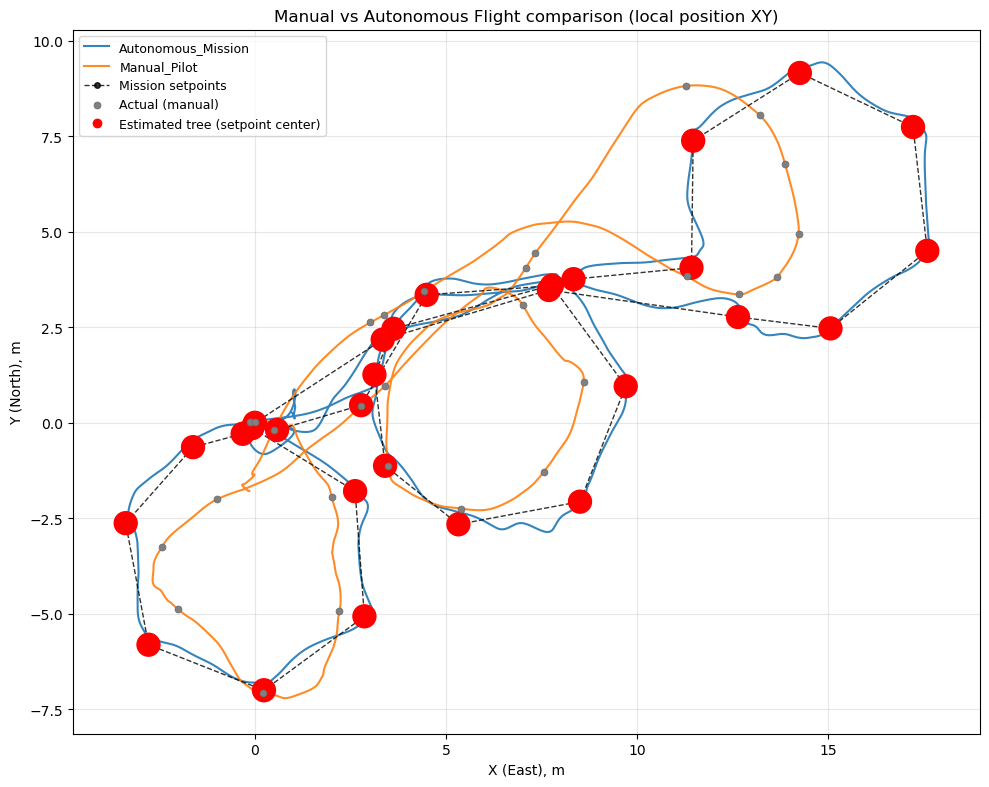

In [17]:
# Overlay plot: both flights + mission setpoints
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.set_aspect("equal")
colors = plt.cm.tab10.colors

for i, path in enumerate([ulog_path_1, ulog_path_2]):
    ts, x, y = load_local_position_xy(path)
    if apply_ned_to_enu:
        x, y = y.copy(), x.copy()  # 90° NED→ENU: (North,East) -> (East,North)
    label = Path(path).stem
    ax.plot(x, y, "-", color=colors[i % len(colors)], label=label, linewidth=1.5, alpha=0.9)

if mission_csv:
    mx, my = load_mission_setpoints(mission_csv)  # already ENU (X=East, Y=North)
    ax.plot(mx, my, "k--", marker="o", markersize=4, label="Mission setpoints", linewidth=1, alpha=0.8)

# X = East, Y = North (ENU)
if apply_ned_to_enu:
    ax.set_xlabel("X (East), m")
    ax.set_ylabel("Y (North), m")
else:
    ax.set_xlabel("X (North, NED), m")
    ax.set_ylabel("Y (East, NED), m")
ax.legend(loc="best", fontsize=9)
ax.grid(True, alpha=0.3)
ax.set_title("Manual vs Autonomous Flight comparison (local position XY)")
plt.tight_layout()
plt.show()